In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
SRC_DIR = '../'
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

In [4]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import torch
from omegaconf import OmegaConf

import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import wandb

### Configure Analysis

In [5]:
DATA_PATH = '/braid/havivd/hbca_immune/hbca_immune.h5ad'
MODEL_PATH = '/braid/havivd/hbca_immune/hbca_immune_model.pth'

In [6]:
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = True

In [7]:
adata = ad.read_h5ad(DATA_PATH)

In [8]:
adata

AnnData object with n_obs × n_vars = 25382 × 16918
    obs: 'sampleID', 'sample_type_coarse', 'sample_type', 'processing_date', 'dissociation_minutes', 'parity', 'brca_status', 'condition', 'tissue_condition', 'reported_ethnicity', 'BMI', 'prob_spikein', 'prob_spikein_dblt', 'pred_spikein', 'n_genes', 'percent_mito', 'n_counts', 'level0_global', 'level1_global', 'level0', 'level1', 'level2', 'scrublet_score', 'scrublet_cluster_score', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'donor_age', 'risk_status', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', '

### Dataset Stats


In [9]:
adata

AnnData object with n_obs × n_vars = 25382 × 16918
    obs: 'sampleID', 'sample_type_coarse', 'sample_type', 'processing_date', 'dissociation_minutes', 'parity', 'brca_status', 'condition', 'tissue_condition', 'reported_ethnicity', 'BMI', 'prob_spikein', 'prob_spikein_dblt', 'pred_spikein', 'n_genes', 'percent_mito', 'n_counts', 'level0_global', 'level1_global', 'level0', 'level1', 'level2', 'scrublet_score', 'scrublet_cluster_score', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'donor_age', 'risk_status', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', '

In [10]:
n_obs,n_concepts = adata.obsm['concepts_soft'].shape
n_samples = adata.obs['sampleID'].unique().shape[0]
n_types = adata.obs['cell_type'].unique().shape[0]

print('cells: {}'.format(n_obs))
print('concepts: {}'.format(n_concepts))
print('samples: {}'.format(n_samples))
print('cell types: {}'.format(n_types))

cells: 25382
concepts: 86
samples: 113
cell types: 15


Filter cells

In [11]:
sc.pp.filter_genes(adata, min_cells= 0.01)
sc.pp.filter_genes(adata, min_counts= 200)

Normalize Data

In [12]:
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

Plot cellxgene umap data, this will be different from ours later on

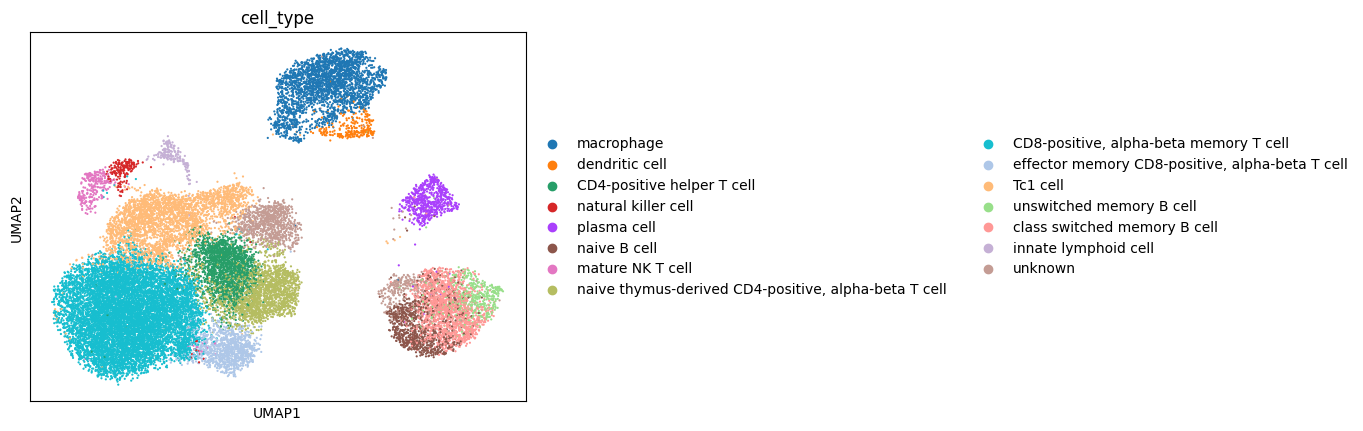

In [13]:
# plot umap of adata colored by cell type
sc.pl.umap(adata, color= 'cell_type', size = 10)

Inspect concepts

/tmp/ipykernel_649731/3085203759.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


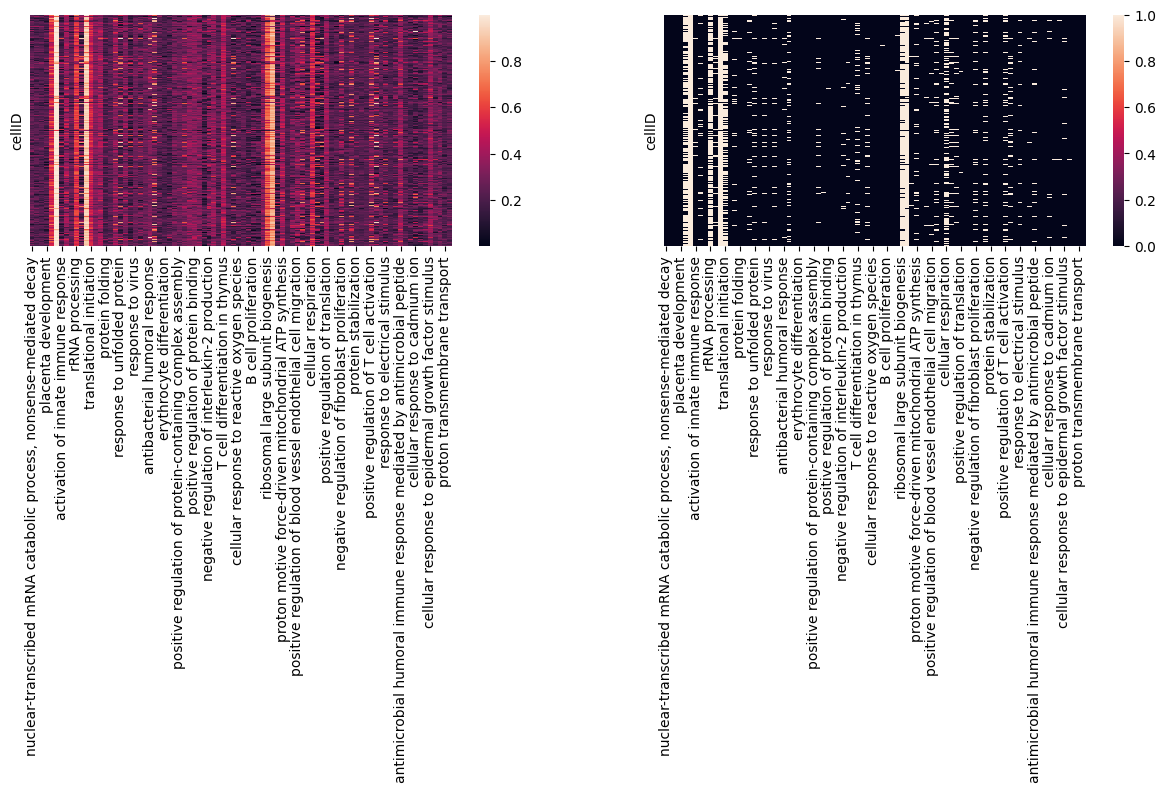

In [14]:
fig,ax = plt.subplots(1,2, figsize = ( 15, 3))
sns.heatmap(adata.obsm['concepts_soft'], ax = ax[0])
sns.heatmap(adata.obsm['concepts_hard'], ax = ax[1])
for axx in ax:
    axx.set_yticks([])
fig.tight_layout()
plt.show()

### Analysis Setup

In [15]:
concept_key = 'concepts_soft'

Set random seed

In [16]:
np.random.seed(69)
torch.manual_seed(69)

Set model config

In [17]:
n_concepts = adata.obsm[concept_key].shape[1]

config_dict = dict(has_cbm = True, 
                   lr = 5e-4,
                   hidden_dim = 128,
                   beta = 1e-5,
                   input_dim = adata.shape[1],
                   latent_dim = 64,
                   n_concepts = n_concepts,
                   min_bottleneck_size = 8, # important
                   independent_training = True,
                   concepts_hp = 0.005,
                   orthogonality_hp = 1, # important
                   use_soft_concepts = True,
                  )

config = OmegaConf.create(config_dict)

model = clab.models.scCBGM(config)

Define train test split

In [18]:
p_test = 0.2
n_test = int(len(adata) * p_test)
n_train = len(adata) - n_test

Get split idxs

In [19]:
ixs = np.arange(len(adata))
np.random.shuffle(ixs)
train_idx = ixs[0:n_train]
test_idx = ixs[n_train::]

Split data

In [20]:
adata_train, adata_test = adata[train_idx].copy(), adata[test_idx].copy()

Create dataset

In [21]:
data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        add_concepts=True,
        concept_key=concept_key,
        batch_size=512,
        normalize=False,
    )

Setup logger

In [22]:
if not USE_SAVED_MODEL:
    wandb_logger = WandbLogger(
            project='pathway_demo_001',
            log_model=False,
        )

Setup Trainer

In [23]:
if not USE_SAVED_MODEL:
    trainer = pl.Trainer(
            max_epochs=200, log_every_n_steps = 10,
        )


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /homefs/home/havivd/miniforge3/envs/conceptlab/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the M

Fit model

In [24]:
if not USE_SAVED_MODEL:
    trainer.fit(model, data_module,)
    if OVERWRITE_SAVED_MODEL: torch.save(model.state_dict(), MODEL_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                | Params | Mode 
-------------------------------------------------------------------
0 | _encoder           | DefaultEncoderBlock | 1.3 M  | train
1 | cb_concepts_layers | Sequential          | 5.6 K  | train
2 | cb_unk_layers      | Sequential          | 5.6 K  | train
3 | _decoder           | SkipDecoderBlock    | 2.1 M  | train
4 | dropout            | Dropout             | 0      | train
-------------------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.444    Total 

Epoch 199: 100%|██████████| 32/32 [00:00<00:00, 50.28it/s, v_num=1]        

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 32/32 [00:00<00:00, 39.45it/s, v_num=1]


Move to CPU

In [25]:
model.to("cpu")
model.eval()


scCBGM(
  (_encoder): DefaultEncoderBlock(
    (encoder_layers): Sequential(
      (0): Linear(in_features=9653, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=128, out_features=64, bias=True)
    (fc_var): Linear(in_features=128, out_features=64, bias=True)
  )
  (cb_concepts_layers): Sequential(
    (0): Linear(in_features=64, out_features=86, bias=True)
    (1): Sigmoid()
  )
  (cb_unk_layers): Sequential(
    (0): Linear(in_features=64, out_features=86, bias=True)
    (1): ReLU()
  )
  (_decoder): SkipDecoderBlock(
    (decoder_layers): Sequential(
      (0): SkipLayer(
        (fc): Linear(in_features=172, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): SkipLayer(
        (fc): Linear(in_features=214, out_features=9653, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

### Evaluate on Test Data

Get test data

In [26]:
x_intervene_on = adata_test.to_df().values.astype(np.float32).copy()
c_intervene_on =  adata_test.obsm[concept_key].values.astype(np.float32).copy()

Get predictions

In [27]:
test_preds = model(torch.tensor(x_intervene_on))

Get predicitions

In [28]:
x_test_preds = test_preds['x_pred'].detach().cpu().numpy()

Convert to anndata

In [29]:
adata_test_pred = ad.AnnData(x_test_preds,
                        var = adata_test.var,
                        obs = adata_test.obs,
                       )

Join test and pred

In [30]:
adata_merge = ad.concat(dict(test_pred = adata_test_pred, test_GT = adata_test), label='ident')

/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Process data for visualization

In [31]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Plot UMAP

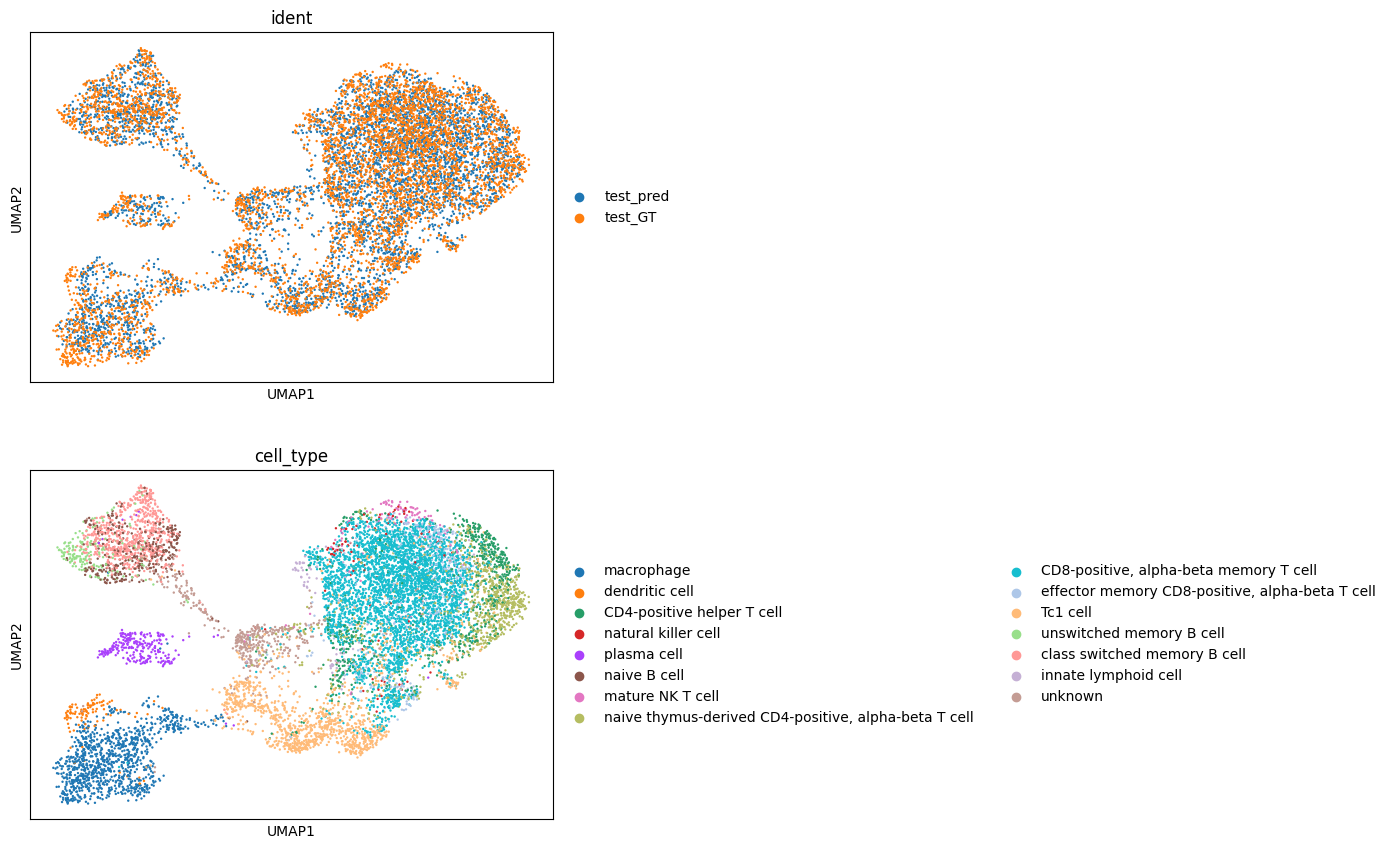

In [32]:
sc.pl.umap(sub_adata, color = ['ident','cell_type'], ncols=1)

## Intervention

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

Define helper function

In [34]:
def get_intervention(x_intervene_on, c_intervene_on, data, concept_name, concept_index, value = 1):
    # Mask ---
    mask = np.zeros_like(c_intervene_on)
    mask = torch.tensor(mask.astype(np.float32))
    
    # On ---
    inter_concepts = c_intervene_on.copy()
    inter_concepts[:,concept_index] = value
    mask[:,concept_index] = 1
    
    
    inter_concepts = torch.tensor(inter_concepts.astype(np.float32))
    inter_preds = model.intervene(torch.tensor(x_intervene_on), mask = mask, concepts= inter_concepts)
    
    x_inter_preds = inter_preds['x_pred'].detach().cpu().numpy()
  
    pred_df = pd.DataFrame(x_inter_preds,
                            index = data.obs.index,
                            columns = data.var.index,
                             )
   

    return pred_df

Test intervention on each pathway, we compare on vs. off

In [35]:
scores = dict()
curves = dict()

for pix,inter_pathway in enumerate(adata.obsm[concept_key].columns):
    
    x_inter_preds_on = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 1)
    x_inter_preds_off = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 0)

    
    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,inter_pathway]
    D = pd.Series(pred_df_on.mean(axis=0) - pred_df_off.mean(axis=0),
                         index = adata_test.var_names,
                        )
    
    scores[inter_pathway] = roc_auc_score(P,D)
    curves[inter_pathway] = roc_curve(P,D)


KeyboardInterrupt: 

Convert to dataframe

In [ ]:
df_auroc = pd.DataFrame(pd.Series(scores), columns = ['AUROC'])
df_auroc

Get continous increase of pathway activation

In [ ]:
pathway_name = 'cellular response to type II interferon'
concept_idx = adata.obsm[concept_key].columns.get_loc(pathway_name)

x_inter_preds_off = get_intervention(x_intervene_on,
                                     c_intervene_on,
                                     adata_test,
                                     pathway_name,
                                     concept_idx,
                                     value = 0)

deltas = dict()

for k,v in enumerate(np.linspace(0.1,1,5)):

    x_inter_preds_on = get_intervention(x_intervene_on,
                                        c_intervene_on,
                                        adata_test,
                                        pathway_name,
                                        concept_idx,
                                        value = v)


    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,pathway_name]
    is_P = P.index[(P == 1).values]
    D = pred_df_on.loc[:,is_P].mean(axis=1) - pred_df_off.loc[:,is_P].mean(axis=1)

    
    
    deltas[v] = D


In [ ]:
display_pathways = ['T cell activation',
                    'proton transmembrane transport',
                    'cellular respiration',
                   ]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string

# Create a figure
fig = plt.figure(figsize=(20, 7))

gs = GridSpec(2, 4, figure=fig) 
  
letters = string.ascii_uppercase

for k,key in enumerate(display_pathways):
    if k > 3:
        break
    ax1 = fig.add_subplot(gs[0, k])
    
    ax1.plot(curves[key][0], curves[key][1], color = 'blue')
    ax1.plot([0,1],[0,1], linestyle = 'dashed', color = 'black',)
    title = '\n'.join([key[i:i+20] for i in range(0, len(key), 20)])
    ax1.set_title(letters[k] + ') ' + title)
    ax1.set_ylabel('TPR')
    ax1.set_xlabel('FPR')

ax2 = fig.add_subplot(gs[1, 0:1])  

k += 1
sc.pl.umap(sub_adata,
           color = ['cell_type'],
           ncols=1,
           ax = ax2,
           show = False,
           legend_loc = 'none',
          )

ax2.set_title(letters[k] + ') ' + 'Cell Type')


ax3 = fig.add_subplot(gs[1, 1:2])
k += 1 

sc.pl.umap(sub_adata,
           color = ['ident'],
           ncols=1,
           ax = ax3,
           show = False,
           legend_loc="upper left",
          )

ax3.set_title(letters[k] + ') ' + 'Spilt')

ax4 = fig.add_subplot(gs[1, 2])

sns.violinplot(pd.DataFrame(deltas), ax = ax4)
ax4.set_xlabel("Activation Value (v)")
ax4.set_ylabel("Expression Difference: On(v) - Off")
ax4.set_title(letters[k] + ') ' + pathway_name)

fig.tight_layout()

# Flow Matching 

In [36]:
import importlib
import sklearn.decomposition
importlib.reload(clab)

import conceptlab as clab

In [38]:
enc = model.encode(torch.tensor(adata.X.astype(np.float32)))
z = model.reparametrize(**enc)

adata.obsm['scCBGM_concepts_known'] = model.cb_concepts_layers(z['z']).detach().cpu().numpy()
adata.obsm['scCBGM_concepts_unknown'] = model.cb_unk_layers(z['z']).detach().cpu().numpy()

adata.obsm['scCBGM_concepts'] = np.concatenate([adata.obsm['scCBGM_concepts_known'], adata.obsm['scCBGM_concepts_unknown']], axis=-1)

In [40]:
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=512).fit(adata.X)
adata.obsm['X_pca'] = adata.uns['pc_transform'].transform(adata.X)

# sc.pp.pca(adata, n_comps = 512)
adata_train.obsm['X_pca'] = adata[adata_train.obs.index].obsm['X_pca']
adata_test.obsm['X_pca'] = adata[adata_test.obs.index].obsm['X_pca']

adata_train.obsm['scCBGM_concepts'] = adata[adata_train.obs.index].obsm['scCBGM_concepts']
adata_test.obsm['scCBGM_concepts'] = adata[adata_test.obs.index].obsm['scCBGM_concepts']

In [42]:
fm_model = clab.models.cb_fm.CB_FM(x_dim=adata_train.obsm['X_pca'].shape[-1], c_dim=adata_train.obsm['scCBGM_concepts'].shape[-1], emb_dim=512, n_layers=4)
fm_model_raw = clab.models.cb_fm.CB_FM(x_dim=adata_train.obsm['X_pca'].shape[-1], c_dim=adata_train.obsm['concepts_soft'].to_numpy().shape[-1], emb_dim=512, n_layers=4)

In [43]:
fm_model.train(
    data=torch.from_numpy(adata_train.obsm['X_pca']).float(),
    concepts=torch.from_numpy(adata_train.obsm['scCBGM_concepts']).float(),
    num_epochs=1000,
    batch_size=128,
    lr=3e-4,
    p_drop=0.1,
    ot = False
)



Training FM for 1000 epochs, with a batch size of 128 and ot False, using the adam optimizer with lr = 0.0003 and 0.998 decay


Epoch 1000/1000 | Loss: 1.7028: 100%|███████████████| 1000/1000 [08:10<00:00,  2.04it/s]


In [44]:
fm_model_raw.train(
    data=torch.from_numpy(adata_train.obsm['X_pca']).float(),
    concepts=torch.from_numpy(adata_train.obsm['concepts_soft'].to_numpy()).float(),
    num_epochs=1000,
    batch_size=128,
    lr=3e-4,
    p_drop=0.0,
    ot = False
)



Training FM for 1000 epochs, with a batch size of 128 and ot False, using the adam optimizer with lr = 0.0003 and 0.998 decay


Epoch 2/1000 | Loss: 2.1995:   0%|                     | 2/1000 [00:01<13:14,  1.26it/s]


KeyboardInterrupt: 

In [47]:
# generate based on adata_test concepts and see that they match the expected output

batch_size = 1024
concetps_split = np.array_split(adata.obsm['scCBGM_concepts'], adata.shape[0]//batch_size)
x_sampled = []

for ind, concepts_batch in enumerate(concetps_split):
    print(f"Processing batch {ind} out of {len(concetps_split)}")
    x_batch = fm_model.sample(concepts = torch.from_numpy(concepts_batch).float(),
                    num_samples = concepts_batch.shape[0],
                    timesteps = 1000,
                    w_uncond = 1.5)
    x_sampled.append(x_batch.cpu().numpy())

x_sampled = np.concatenate(x_sampled, axis = 0)
                

Processing batch 0 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling:   4%|█▋                                    | 45/1000 [00:00<00:02, 431.11it/s]

Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 423.86it/s]


Processing batch 1 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 336.20it/s]


Processing batch 2 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 652.26it/s]


Processing batch 3 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 968.54it/s]


Processing batch 4 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 898.96it/s]


Processing batch 5 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 956.37it/s]


Processing batch 6 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 875.46it/s]


Processing batch 7 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 909.24it/s]


Processing batch 8 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 887.13it/s]


Processing batch 9 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 937.64it/s]


Processing batch 10 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 966.62it/s]


Processing batch 11 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 952.76it/s]


Processing batch 12 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 965.51it/s]


Processing batch 13 out of 24
Generating 1058 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 940.11it/s]


Processing batch 14 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 946.47it/s]


Processing batch 15 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 964.27it/s]


Processing batch 16 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 827.22it/s]


Processing batch 17 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 941.24it/s]


Processing batch 18 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 929.20it/s]


Processing batch 19 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 956.55it/s]


Processing batch 20 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 924.42it/s]


Processing batch 21 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 960.96it/s]


Processing batch 22 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 931.66it/s]


Processing batch 23 out of 24
Generating 1057 samples with w_uncond=1.5


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 858.97it/s]


## Plot

In [ ]:
# adata_pred = ad.AnnData(x_sampled,
#                         var = adata.var,
#                         obs = adata.obs,
#                        )

# adata_merge = ad.concat(dict(test_pred = adata_pred, test_GT = adata), label='ident')

# sc.pp.pca(adata_merge)
# sc.pp.neighbors(adata_merge)
# sc.tl.umap(adata_merge, random_state=69)

# sc.pl.umap(adata_merge, color = ['ident','cell_type'], ncols=1)

In [48]:
import umap
import seaborn as sns



In [49]:
# Concatenate x_sampled and adata_test.obsm['X_pca']
X_concat = np.concatenate([x_sampled, adata.obsm['X_pca']], axis=0)

# Fit UMAP on concatenated data
umap_embed = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_concat)

n = x_sampled.shape[0]
umap_sampled = umap_embed[:n]
umap_pca = umap_embed[n:]

cell_types = adata.obs['cell_type'].values



/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


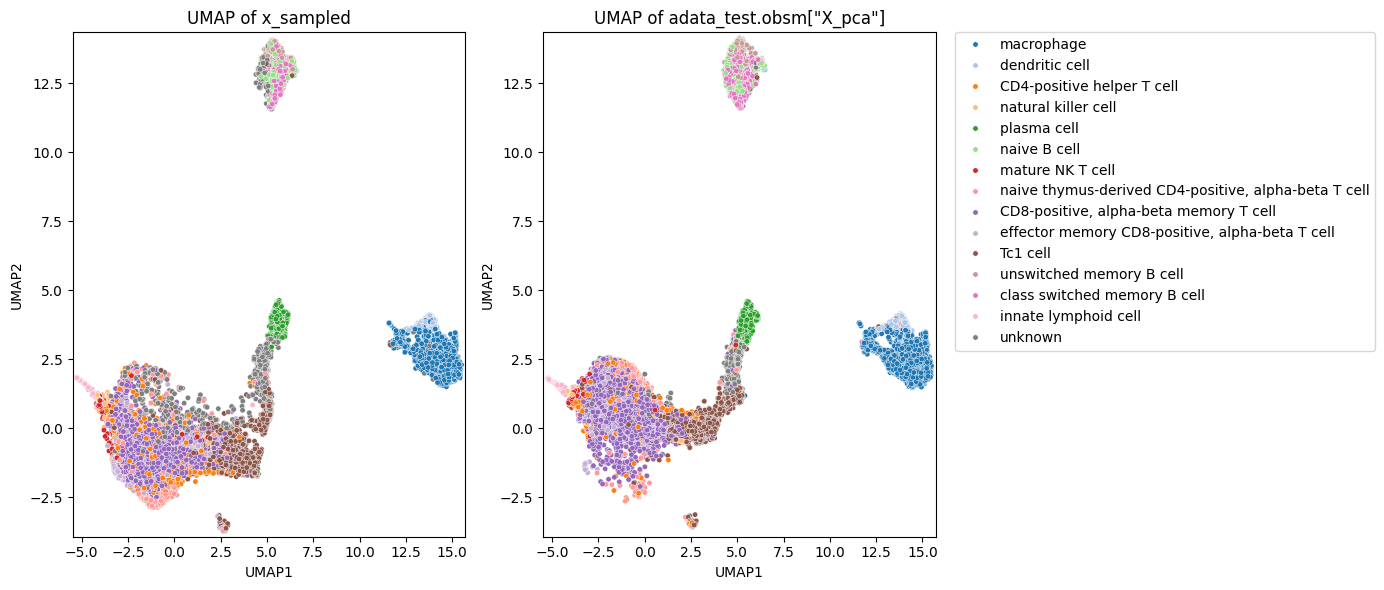

In [50]:
# --- Plotting with Seaborn (without DataFrames) ---

xmin = umap_embed[:, 0].min() - 0.2
xmax = umap_embed[:, 0].max() + 0.2
ymin = umap_embed[:, 1].min() - 0.2
ymax = umap_embed[:, 1].max() + 0.2

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: UMAP of x_sampled
sns.scatterplot(
    x=umap_sampled[:, 0],  # Pass UMAP1 coordinates directly
    y=umap_sampled[:, 1],  # Pass UMAP2 coordinates directly
    hue=cell_types,        # Pass the cell type array for color
    palette='tab20',
    s=15,
    ax=axes[0],
    legend=False           # Hide legend to avoid duplication
)
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_title('UMAP of x_sampled')
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')

# Plot 2: UMAP of adata_test PCA
sns.scatterplot(
    x=umap_pca[:, 0],
    y=umap_pca[:, 1],
    hue=cell_types,
    palette='tab20',
    s=15,
    ax=axes[1]
)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_title('UMAP of adata_test.obsm["X_pca"]')
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

# Adjust the legend and layout
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Intervention

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

Define helper function

In [55]:
c_intervene_on =  adata_test.obsm['scCBGM_concepts'].astype(np.float32).copy()

In [ ]:
def get_intervention(x_intervene_on, c_intervene_on, data, concept_name, concept_index, value = 1, neg_concepts = True):
    # Mask ---
    mask = np.zeros_like(c_intervene_on)
    mask = torch.tensor(mask.astype(np.float32))
    
    # On ---
    inter_concepts = c_intervene_on.copy()
    inter_concepts[:,concept_index] = value
    mask[:,concept_index] = 1
    
    
    inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

    if(neg_concepts):
        # Sample with negative concepts
        inter_preds = fm_model.sample(concepts = inter_concepts,
                    negative_concepts = torch.tensor(c_intervene_on.astype(np.float32)),
                    num_samples = inter_concepts.shape[0],
                    timesteps = 1000,
                    w_uncond = 2,
                    w_neg = 1)
    else:
        inter_preds = fm_model.sample(concepts = inter_concepts,
                        num_samples = inter_concepts.shape[0],
                        timesteps = 1000,
                        w_uncond = 2)
    
    inter_preds = inter_preds.detach().cpu().numpy()
    x_inter_preds = adata.uns['pc_transform'].inverse_transform(inter_preds)
    pred_df = pd.DataFrame(x_inter_preds,
                            index = data.obs.index,
                            columns = data.var.index,
                             )
   

    return pred_df

Test intervention on each pathway, we compare on vs. off

In [57]:
scores = dict()
curves = dict()

for pix,inter_pathway in enumerate(adata.obsm[concept_key].columns):
    
    x_inter_preds_on = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 1)
    x_inter_preds_off = get_intervention(x_intervene_on, c_intervene_on, adata_test, inter_pathway, pix, value = 0)

    
    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,inter_pathway]
    D = pd.Series(pred_df_on.mean(axis=0) - pred_df_off.mean(axis=0),
                         index = adata_test.var_names,
                        )
    
    scores[inter_pathway] = roc_auc_score(P,D)
    curves[inter_pathway] = roc_curve(P,D)


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:03<00:00, 331.42it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 380.93it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.92it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 384.58it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 384.24it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.16it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.58it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.34it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.37it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:05<00:00, 197.44it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.22it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.21it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.10it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.14it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.34it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.24it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.05it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.24it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.24it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.23it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.17it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.21it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.18it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.16it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.21it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.23it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.44it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.45it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.44it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.14it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.34it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 385.78it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.26it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.10it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.34it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.35it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.34it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.35it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.31it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.25it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.28it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.27it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 380.98it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 384.91it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.29it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.32it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.33it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.36it/s]


Convert to dataframe

In [58]:
df_auroc = pd.DataFrame(pd.Series(scores), columns = ['AUROC'])
df_auroc

,AUROC
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay",0.705200
"regulation of alternative mRNA splicing, via spliceosome",0.873367
"mRNA splicing, via spliceosome",0.759100
placenta development,0.772300
positive regulation of T cell mediated cytotoxicity,0.843005
...,...
cellular response to epidermal growth factor stimulus,0.630533
liver regeneration,0.823317
regulation of signal transduction by p53 class mediator,0.608542
proton transmembrane transport,0.765838


Get continous increase of pathway activation

In [59]:
pathway_name = 'cellular response to type II interferon'
concept_idx = adata.obsm[concept_key].columns.get_loc(pathway_name)

x_inter_preds_off = get_intervention(x_intervene_on,
                                     c_intervene_on,
                                     adata_test,
                                     pathway_name,
                                     concept_idx,
                                     value = 0)

deltas = dict()

for k,v in enumerate(np.linspace(0.1,1,5)):

    x_inter_preds_on = get_intervention(x_intervene_on,
                                        c_intervene_on,
                                        adata_test,
                                        pathway_name,
                                        concept_idx,
                                        value = v)


    # Create DataFrames
    pred_df_on = pd.DataFrame(x_inter_preds_on,
                              index = adata_test.obs.index,
                              columns = adata_test.var.index,
                             )
    
    pred_df_off = pd.DataFrame(x_inter_preds_off,
                               index = adata_test.obs.index,
                               columns = adata_test.var.index,
                              )
    
    P = adata.varm['concept_coef'].loc[:,pathway_name]
    is_P = P.index[(P == 1).values]
    D = pred_df_on.loc[:,is_P].mean(axis=1) - pred_df_off.loc[:,is_P].mean(axis=1)

    
    
    deltas[v] = D


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.18it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.07it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.21it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.35it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.38it/s]


Generating 5076 samples with w_uncond=2 and w_neg=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:02<00:00, 386.30it/s]


In [60]:
display_pathways = ['T cell activation',
                    'proton transmembrane transport',
                    'cellular respiration',
                   ]

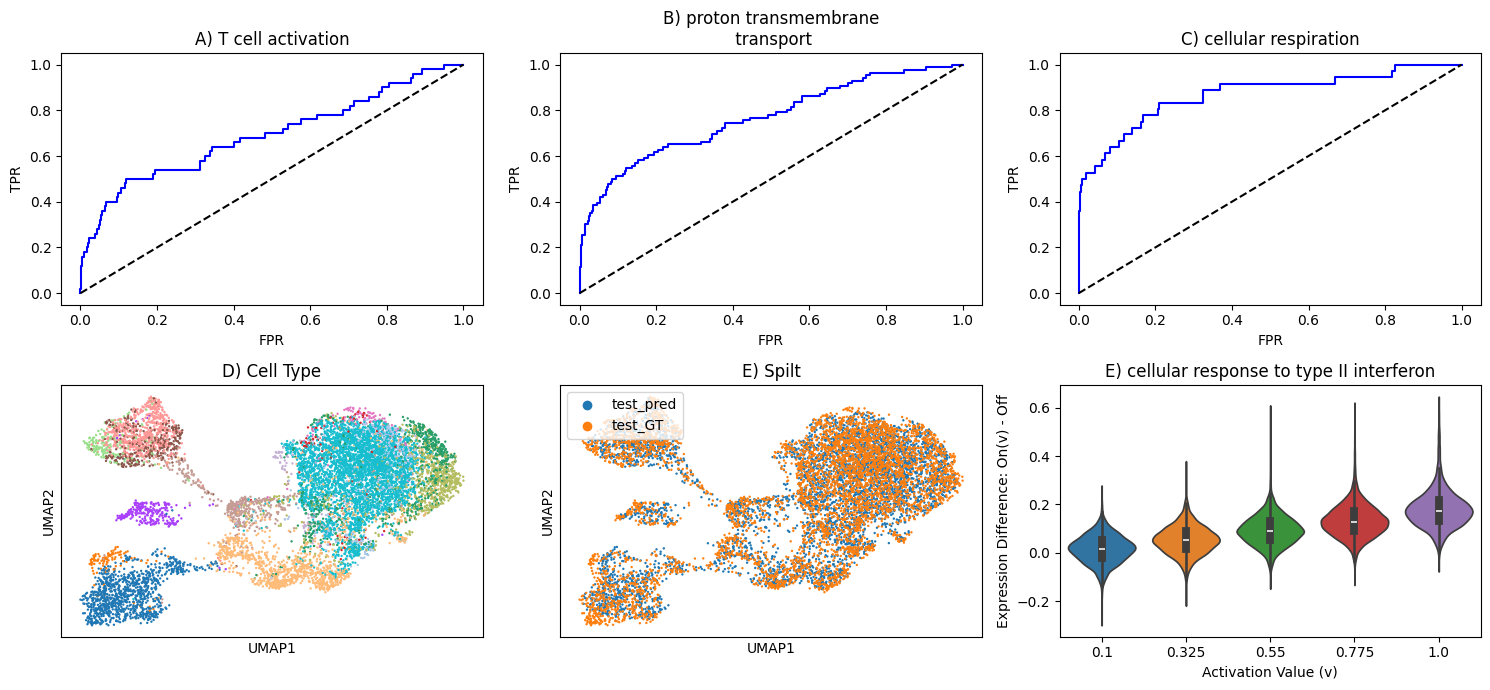

In [61]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string

# Create a figure
fig = plt.figure(figsize=(20, 7))

gs = GridSpec(2, 4, figure=fig) 
  
letters = string.ascii_uppercase

for k,key in enumerate(display_pathways):
    if k > 3:
        break
    ax1 = fig.add_subplot(gs[0, k])
    
    ax1.plot(curves[key][0], curves[key][1], color = 'blue')
    ax1.plot([0,1],[0,1], linestyle = 'dashed', color = 'black',)
    title = '\n'.join([key[i:i+20] for i in range(0, len(key), 20)])
    ax1.set_title(letters[k] + ') ' + title)
    ax1.set_ylabel('TPR')
    ax1.set_xlabel('FPR')

ax2 = fig.add_subplot(gs[1, 0:1])  

k += 1
sc.pl.umap(sub_adata,
           color = ['cell_type'],
           ncols=1,
           ax = ax2,
           show = False,
           legend_loc = 'none',
          )

ax2.set_title(letters[k] + ') ' + 'Cell Type')


ax3 = fig.add_subplot(gs[1, 1:2])
k += 1 

sc.pl.umap(sub_adata,
           color = ['ident'],
           ncols=1,
           ax = ax3,
           show = False,
           legend_loc="upper left",
          )

ax3.set_title(letters[k] + ') ' + 'Spilt')

ax4 = fig.add_subplot(gs[1, 2])

sns.violinplot(pd.DataFrame(deltas), ax = ax4)
ax4.set_xlabel("Activation Value (v)")
ax4.set_ylabel("Expression Difference: On(v) - Off")
ax4.set_title(letters[k] + ') ' + pathway_name)

fig.tight_layout()